In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v11 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-16 01:51:10.381744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 01:51:10.382191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 01:51:10.445289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 01:51:10.445688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 01:51:10.445985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-16 01:51:10.447796: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 01:51:10.448359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 01:51:10.448570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 01:51:10.448757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '000'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    N_ref = int(np.array(f['N_ref']))
    
    try:
        u_ref = np.array(f['u_reference'], dtype=FTYPE)
        v_ref = np.array(f['v_reference'], dtype=FTYPE)
    except:
        uh = np.empty(shape=(len(t_recorded_samples), 2*N+1, 2*N+1), dtype=np.complex128)
        uh[:, :, N:] = np.array(f['uh'])
        uh[:, 0:N, 0:N] = np.conjugate(uh[:, N+1:, N+1:][:, ::-1, ::-1])
        uh[:, N+1:, 0:N] = np.conjugate(uh[:, 0:N, N+1:][:, ::-1, ::-1])

        vh = np.empty(shape=(len(t_recorded_samples), 2*N+1, 2*N+1), dtype=np.complex128)
        vh[:, :, N:] = np.array(f['vh'])
        vh[:, 0:N, 0:N] = np.conjugate(vh[:, N+1:, N+1:][:, ::-1, ::-1])
        vh[:, N+1:, 0:N] = np.conjugate(vh[:, 0:N, N+1:][:, ::-1, ::-1])

        u_ref = np.fft.irfft2(np.fft.ifftshift(uh), s=(N_ref, N_ref))
        del(uh)
        v_ref = np.fft.irfft2(np.fft.ifftshift(vh), s=(N_ref, N_ref))
        del(vh)

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_053
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2,) + tuple(all_data.shape[1:]), dtype=FTYPE)
        if normalization_type == 'stddev':
            normalization_constant_arr_aedata[0] = np.mean(all_data, axis=0)
            normalization_constant_arr_aedata[1] = stddev_multiplier * np.std(all_data, axis=0)
        elif normalization_type == 'minmax':
            sample_min = all_data.min(axis=0)
            sample_max = all_data.max(axis=0)
            idx = np.where(sample_min == sample_max)
            if len(idx) > 0:
                num_elems = len(idx[0])
                for i in range(num_elems):
                    i0 = idx[0][i]
                    i1 = idx[1][i]
                    i2 = idx[2][i]
                    sample_min[i0, i1, i2] -= 0.5
                    sample_max[i0, i1, i2] = sample_min[i0, i1, i2] + 1.
            normalization_constant_arr_aedata[0] = sample_min
            normalization_constant_arr_aedata[1] = sample_max - sample_min
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        # 'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':False,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
time_stddev = np.std(all_data, axis=0)

In [15]:
# all_data = all_data[::4]

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 2/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev)
    use_weights_post_dense = False
    use_batch_norm = True

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'use_batch_norm':use_batch_norm,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [18]:
num_train = int(all_data.shape[0]*train_split)
num_val = int(all_data.shape[0]*val_split)
num_test = all_data.shape[0] - num_train - num_val

idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data.shape[1:]), dtype=FTYPE)

training_data[:] = all_data[idx[0:num_train]]
val_data[:] = all_data[idx[num_train:num_train+num_val]]
testing_data[:] = all_data[idx[num_train+num_val:]]

In [19]:
del(all_data)

In [20]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    enc_filters = [8, 16, 32, 10, 5] # [8, 3, 1]
    enc_strides = [2, 2, 2, 2, 1] # [2, 1, 1]
    enc_attn_placement = [1, 2, 3]
    dec_filters = [10, 32, 16, 8, 2]# [3, 8, 2]
    dec_strides = [1, 2, 2, 2, 2] # [1, 1, 2]
    dec_attn_placement = [0, 1]
    kernel_size = [3, 5, 7]
    ls_dim = 0
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    use_periodic_padding = True
    use_attention_module = True
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=training_data.shape[1:],
                kernel_size=kernel_size,
                enc_filters=enc_filters, # number of filters
                dec_filters=dec_filters, # number of filters
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                use_weights_post_dense=use_weights_post_dense,
                use_batch_norm=use_batch_norm,
                use_periodic_padding=use_periodic_padding,
                use_attention_module=use_attention_module,
                enc_strides=enc_strides,
                enc_attn_placement=enc_attn_placement,
                dec_strides=dec_strides,
                dec_attn_placement=dec_attn_placement,
                ls_dim=ls_dim,)
    else:
        ae_net = Autoencoder(
            data_dim=training_data.shape[1:],
            kernel_size=kernel_size,
            enc_filters=enc_filters, # number of filters
            dec_filters=dec_filters, # number of filters
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            use_weights_post_dense=use_weights_post_dense,
            use_batch_norm=use_batch_norm,
            use_periodic_padding=use_periodic_padding,
            use_attention_module=use_attention_module,
            enc_strides=enc_strides,
            enc_attn_placement=enc_attn_placement,
            dec_strides=dec_strides,
            dec_attn_placement=dec_attn_placement,
            ls_dim=ls_dim,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


2023-06-16 01:51:22.742668: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [22]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

if use_attention_module == True:
    encoder_attention_lambdas = {}
    decoder_attention_lambdas = {}
    for ks_i in range(len(ae_net.kernel_size)):
        for i in range(len(ae_net.encoder_attention_modules_list[ks_i])):
            # l = ae_net.encoder_attention_modules_list[i]
            encoder_attention_lambdas['{}__encoder_attention_module_{}_lambda'.format(ks_i, i)] = [0]
        for i in range(len(ae_net.decoder_attention_modules_list[ks_i])):
            # l = ae_net.decoder_attention_modules_list[i]
            decoder_attention_lambdas['{}__decoder_attention_module_{}_lambda'.format(ks_i, i)] = [0]

In [23]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [24]:
if strategy is not None:
    with strategy.scope():
        NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))
else:
    NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))

In [25]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE_metric]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        if use_attention_module == True:
            for ks_i in range(len(ae_net.kernel_size)):
                for j in range(len(ae_net.encoder_attention_modules_list[ks_i])):
                    key = '{}__encoder_attention_module_{}_lambda'.format(ks_i, j)
                    lst1 = history.history[key]
                    lst2 = encoder_attention_lambdas[key]
                    lst2.extend(lst1)
                    encoder_attention_lambdas[key] = lst2
                for j in range(len(ae_net.decoder_attention_modules_list[ks_i])):
                    key = '{}__decoder_attention_module_{}_lambda'.format(ks_i, j)
                    lst1 = history.history[key]
                    lst2 = decoder_attention_lambdas[key]
                    lst2.extend(lst1)
                    decoder_attention_lambdas[key] = lst2
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0118 - NMSE: 0.1064 - 0__encoder_attention_module_0_lambda: 0.0335 - 0__encoder_attention_module_1_lambda: 0.0502 - 0__encoder_attention_module_2_lambda: 0.0120 - 0__decoder_attention_module_0_lambda: 0.0698 - 0__decoder_attention_module_1_lambda: -0.1221 - 1__encoder_attention_module_0_lambda: 0.0717 - 1__encoder_attention_module_1_lambda: 0.0248 - 1__encoder_attention_module_2_lambda: 0.0278 - 1__decoder_attention_module_0_lambda: 0.0187 - 1__decoder_attention_module_1_lambda: -0.0936 - 2__encoder_attention_module_0_lambda: -0.0664 - 2__encoder_attention_module_1_lambda: -0.0446 - 2__encoder_attention_module_2_lambda: -0.0202 - 2__decoder_attention_mod

Epoch 8/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 0.0020 - NMSE: 0.0178 - 0__encoder_attention_module_0_lambda: 0.1226 - 0__encoder_attention_module_1_lambda: 0.0511 - 0__encoder_attention_module_2_lambda: 0.0558 - 0__decoder_attention_module_0_lambda: 0.0917 - 0__decoder_attention_module_1_lambda: -0.1698 - 1__encoder_attention_module_0_lambda: 0.1532 - 1__encoder_attention_module_1_lambda: 0.0505 - 1__encoder_attention_module_2_lambda: 0.0362 - 1__decoder_attention_module_0_lambda: 0.0761 - 1__decoder_attention_module_1_lambda: -0.2714 - 2__encoder_attention_module_0_lambda: -0.1682 - 2__encoder_attention_module_1_lambda: -0.0723 - 2__encoder_attention_module_2_lambda: -0.0260 - 2__decoder_attention_module_0_lambda: 0.0583 - 2__decoder_attention_module_1_lambda: 0.3062 - 0__encoded_vec_wt: 0.2971 - 1__encoded_vec_wt: 0.3512 - 2__encoded_vec_wt: 0.3470 - 0__decoded_vec_wt: 0.0772 - 1__decoded_vec_wt: 0.5770 - 2__decoded_vec_wt: 0.5785 - tot_time: 0

Epoch 12/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0018 - NMSE: 0.0158 - 0__encoder_attention_module_0_lambda: 0.1157 - 0__encoder_attention_module_1_lambda: 0.0496 - 0__encoder_attention_module_2_lambda: 0.0515 - 0__decoder_attention_module_0_lambda: 0.1287 - 0__decoder_attention_module_1_lambda: -0.1840 - 1__encoder_attention_module_0_lambda: 0.1832 - 1__encoder_attention_module_1_lambda: 0.0613 - 1__encoder_attention_module_2_lambda: 0.0416 - 1__decoder_attention_module_0_lambda: 0.1074 - 1__decoder_attention_module_1_lambda: -0.3145 - 2__encoder_attention_module_0_lambda: -0.2114 - 2__encoder_attention_module_1_lambda: -0.0909 - 2__encoder_attention_module_2_lambda: -0.0325 - 2__decoder_attention_module_0_lambda: 0.0849 - 2__decoder_attention_module_1_lambda: 0.3372 - 0__encoded_vec_wt: 0.3126 - 1__encoded_vec_wt: 0.3553 - 2__encoded_vec_wt: 0.3295 - 0__decoded_vec_wt: 0.0872 - 1__decoded_vec_wt: 0.6212 - 2__decoded_vec_wt: 0.6506 - tot_time: 

Epoch 16/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0017 - NMSE: 0.0149 - 0__encoder_attention_module_0_lambda: 0.1140 - 0__encoder_attention_module_1_lambda: 0.0500 - 0__encoder_attention_module_2_lambda: 0.0433 - 0__decoder_attention_module_0_lambda: 0.1483 - 0__decoder_attention_module_1_lambda: -0.2139 - 1__encoder_attention_module_0_lambda: 0.2075 - 1__encoder_attention_module_1_lambda: 0.0711 - 1__encoder_attention_module_2_lambda: 0.0476 - 1__decoder_attention_module_0_lambda: 0.1378 - 1__decoder_attention_module_1_lambda: -0.3361 - 2__encoder_attention_module_0_lambda: -0.2507 - 2__encoder_attention_module_1_lambda: -0.1125 - 2__encoder_attention_module_2_lambda: -0.0403 - 2__decoder_attention_module_0_lambda: 0.1093 - 2__decoder_attention_module_1_lambda: 0.3529 - 0__encoded_vec_wt: 0.3296 - 1__encoded_vec_wt: 0.3570 - 2__encoded_vec_wt: 0.3086 - 0__decoded_vec_wt: 0.1097 - 1__decoded_vec_wt: 0.6493 - 2__decoded_vec_wt: 0.7002 - tot_time: 

Epoch 20/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0143 - 0__encoder_attention_module_0_lambda: 0.1136 - 0__encoder_attention_module_1_lambda: 0.0501 - 0__encoder_attention_module_2_lambda: 0.0397 - 0__decoder_attention_module_0_lambda: 0.1676 - 0__decoder_attention_module_1_lambda: -0.2364 - 1__encoder_attention_module_0_lambda: 0.2290 - 1__encoder_attention_module_1_lambda: 0.0842 - 1__encoder_attention_module_2_lambda: 0.0522 - 1__decoder_attention_module_0_lambda: 0.1591 - 1__decoder_attention_module_1_lambda: -0.3505 - 2__encoder_attention_module_0_lambda: -0.2813 - 2__encoder_attention_module_1_lambda: -0.1402 - 2__encoder_attention_module_2_lambda: -0.0479 - 2__decoder_attention_module_0_lambda: 0.1289 - 2__decoder_attention_module_1_lambda: 0.3623 - 0__encoded_vec_wt: 0.3475 - 1__encoded_vec_wt: 0.3559 - 2__encoded_vec_wt: 0.2838 - 0__decoded_vec_wt: 0.1370 - 1__decoded_vec_wt: 0.6721 - 2__decoded_vec_wt: 0.7337 - tot_time: 

Epoch 24/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0015 - NMSE: 0.0139 - 0__encoder_attention_module_0_lambda: 0.1131 - 0__encoder_attention_module_1_lambda: 0.0528 - 0__encoder_attention_module_2_lambda: 0.0418 - 0__decoder_attention_module_0_lambda: 0.1876 - 0__decoder_attention_module_1_lambda: -0.2610 - 1__encoder_attention_module_0_lambda: 0.2508 - 1__encoder_attention_module_1_lambda: 0.0977 - 1__encoder_attention_module_2_lambda: 0.0566 - 1__decoder_attention_module_0_lambda: 0.1711 - 1__decoder_attention_module_1_lambda: -0.3625 - 2__encoder_attention_module_0_lambda: -0.3228 - 2__encoder_attention_module_1_lambda: -0.1584 - 2__encoder_attention_module_2_lambda: -0.0505 - 2__decoder_attention_module_0_lambda: 0.1498 - 2__decoder_attention_module_1_lambda: 0.3652 - 0__encoded_vec_wt: 0.3666 - 1__encoded_vec_wt: 0.3501 - 2__encoded_vec_wt: 0.2558 - 0__decoded_vec_wt: 0.1601 - 1__decoded_vec_wt: 0.6916 - 2__decoded_vec_wt: 0.7595 - tot_time: 

Epoch 28/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0135 - 0__encoder_attention_module_0_lambda: 0.1211 - 0__encoder_attention_module_1_lambda: 0.0531 - 0__encoder_attention_module_2_lambda: 0.0431 - 0__decoder_attention_module_0_lambda: 0.2103 - 0__decoder_attention_module_1_lambda: -0.2781 - 1__encoder_attention_module_0_lambda: 0.2741 - 1__encoder_attention_module_1_lambda: 0.1094 - 1__encoder_attention_module_2_lambda: 0.0557 - 1__decoder_attention_module_0_lambda: 0.1771 - 1__decoder_attention_module_1_lambda: -0.3711 - 2__encoder_attention_module_0_lambda: -0.3557 - 2__encoder_attention_module_1_lambda: -0.1885 - 2__encoder_attention_module_2_lambda: -0.0579 - 2__decoder_attention_module_0_lambda: 0.1766 - 2__decoder_attention_module_1_lambda: 0.3676 - 0__encoded_vec_wt: 0.3822 - 1__encoded_vec_wt: 0.3399 - 2__encoded_vec_wt: 0.2293 - 0__decoded_vec_wt: 0.1799 - 1__decoded_vec_wt: 0.7071 - 2__decoded_vec_wt: 0.7803 - tot_time: 

Epoch 31: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0013 - NMSE: 0.0120 - 0__encoder_attention_module_0_lambda: 0.1140 - 0__encoder_attention_module_1_lambda: 0.0523 - 0__encoder_attention_module_2_lambda: 0.0430 - 0__decoder_attention_module_0_lambda: 0.1774 - 0__decoder_attention_module_1_lambda: -0.2493 - 1__encoder_attention_module_0_lambda: 0.2378 - 1__encoder_attention_module_1_lambda: 0.0868 - 1__encoder_attention_module_2_lambda: 0.0561 - 1__decoder_attention_module_0_lambda: 0.1634 - 1__decoder_attention_module_1_lambda: -0.3540 - 2__encoder_attention_module_0_lambda: -0.3014 - 2__encoder_attention_module_1_lambda: -0.1462 - 2__encoder_attention_module_2_lambda: -0.0470 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_053/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 66s 53ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0116 - 0__encoder_attention_module_0_lambda: 0.1129 - 0__encoder_attention_module_1_lambda: 0.0569 - 0__encoder_attention_module_2_lambda: 0.0438 - 0__decoder_attention_module_0_lambda: 0.1729 - 0__decoder_attention_module_1_lambda: -0.2538 - 1__encoder_attention_module_0_lambda: 0.2421 - 1__encoder_attention_module_1_lambda: 0.0939 - 1__encoder_attention_module_2_lambda: 0.0582 - 1__decoder_attention_module_0_lambda: 0.1620 - 1__decoder_attention_module_1_lambda: -0.3557 - 2__encoder_attention_module_0_lambda: -0.3034 - 2__encoder_attention_module_1_lambda: -0.1570 - 2__encoder_attention_module_2_lambda: -0.0429 - 2__decoder_attention_module_0_lambda: 0.1354 - 2__decoder_attention_module_1_lambda: 0.3694 - 0__encoded_vec_wt: 0.3482 - 1__encoded_vec_wt: 0.3596 - 

Epoch 12/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0113 - 0__encoder_attention_module_0_lambda: 0.1120 - 0__encoder_attention_module_1_lambda: 0.0631 - 0__encoder_attention_module_2_lambda: 0.0477 - 0__decoder_attention_module_0_lambda: 0.1727 - 0__decoder_attention_module_1_lambda: -0.2662 - 1__encoder_attention_module_0_lambda: 0.2451 - 1__encoder_attention_module_1_lambda: 0.1023 - 1__encoder_attention_module_2_lambda: 0.0585 - 1__decoder_attention_module_0_lambda: 0.1631 - 1__decoder_attention_module_1_lambda: -0.3583 - 2__encoder_attention_module_0_lambda: -0.3076 - 2__encoder_attention_module_1_lambda: -0.1702 - 2__encoder_attention_module_2_lambda: -0.0427 - 2__decoder_attention_module_0_lambda: 0.1365 - 2__decoder_attention_module_1_lambda: 0.3725 - 0__encoded_vec_wt: 0.3396 - 1__encoded_vec_wt: 0.3660 - 2__encoded_vec_wt: 0.2764 - 0__decoded_vec_wt: 0.1674 - 1__decoded_vec_wt: 0.6900 - 2__decoded_vec_wt: 0.7581 - tot_time: 

Epoch 16/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0111 - 0__encoder_attention_module_0_lambda: 0.1134 - 0__encoder_attention_module_1_lambda: 0.0654 - 0__encoder_attention_module_2_lambda: 0.0490 - 0__decoder_attention_module_0_lambda: 0.1727 - 0__decoder_attention_module_1_lambda: -0.2713 - 1__encoder_attention_module_0_lambda: 0.2468 - 1__encoder_attention_module_1_lambda: 0.1059 - 1__encoder_attention_module_2_lambda: 0.0598 - 1__decoder_attention_module_0_lambda: 0.1634 - 1__decoder_attention_module_1_lambda: -0.3599 - 2__encoder_attention_module_0_lambda: -0.3103 - 2__encoder_attention_module_1_lambda: -0.1756 - 2__encoder_attention_module_2_lambda: -0.0435 - 2__decoder_attention_module_0_lambda: 0.1379 - 2__decoder_attention_module_1_lambda: 0.3738 - 0__encoded_vec_wt: 0.3366 - 1__encoded_vec_wt: 0.3681 - 2__encoded_vec_wt: 0.2760 - 0__decoded_vec_wt: 0.1719 - 1__decoded_vec_wt: 0.6930 - 2__decoded_vec_wt: 0.7618 - tot_time: 

Epoch 20/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0110 - 0__encoder_attention_module_0_lambda: 0.1145 - 0__encoder_attention_module_1_lambda: 0.0683 - 0__encoder_attention_module_2_lambda: 0.0503 - 0__decoder_attention_module_0_lambda: 0.1732 - 0__decoder_attention_module_1_lambda: -0.2770 - 1__encoder_attention_module_0_lambda: 0.2488 - 1__encoder_attention_module_1_lambda: 0.1098 - 1__encoder_attention_module_2_lambda: 0.0622 - 1__decoder_attention_module_0_lambda: 0.1643 - 1__decoder_attention_module_1_lambda: -0.3610 - 2__encoder_attention_module_0_lambda: -0.3128 - 2__encoder_attention_module_1_lambda: -0.1817 - 2__encoder_attention_module_2_lambda: -0.0448 - 2__decoder_attention_module_0_lambda: 0.1397 - 2__decoder_attention_module_1_lambda: 0.3752 - 0__encoded_vec_wt: 0.3342 - 1__encoded_vec_wt: 0.3698 - 2__encoded_vec_wt: 0.2752 - 0__decoded_vec_wt: 0.1757 - 1__decoded_vec_wt: 0.6957 - 2__decoded_vec_wt: 0.7650 - tot_time: 

Epoch 24/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0110 - 0__encoder_attention_module_0_lambda: 0.1142 - 0__encoder_attention_module_1_lambda: 0.0707 - 0__encoder_attention_module_2_lambda: 0.0516 - 0__decoder_attention_module_0_lambda: 0.1745 - 0__decoder_attention_module_1_lambda: -0.2828 - 1__encoder_attention_module_0_lambda: 0.2498 - 1__encoder_attention_module_1_lambda: 0.1133 - 1__encoder_attention_module_2_lambda: 0.0630 - 1__decoder_attention_module_0_lambda: 0.1650 - 1__decoder_attention_module_1_lambda: -0.3635 - 2__encoder_attention_module_0_lambda: -0.3151 - 2__encoder_attention_module_1_lambda: -0.1872 - 2__encoder_attention_module_2_lambda: -0.0453 - 2__decoder_attention_module_0_lambda: 0.1416 - 2__decoder_attention_module_1_lambda: 0.3764 - 0__encoded_vec_wt: 0.3319 - 1__encoded_vec_wt: 0.3713 - 2__encoded_vec_wt: 0.2741 - 0__decoded_vec_wt: 0.1795 - 1__decoded_vec_wt: 0.6983 - 2__decoded_vec_wt: 0.7685 - tot_time: 

Epoch 28/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0109 - 0__encoder_attention_module_0_lambda: 0.1160 - 0__encoder_attention_module_1_lambda: 0.0729 - 0__encoder_attention_module_2_lambda: 0.0540 - 0__decoder_attention_module_0_lambda: 0.1768 - 0__decoder_attention_module_1_lambda: -0.2877 - 1__encoder_attention_module_0_lambda: 0.2515 - 1__encoder_attention_module_1_lambda: 0.1154 - 1__encoder_attention_module_2_lambda: 0.0637 - 1__decoder_attention_module_0_lambda: 0.1655 - 1__decoder_attention_module_1_lambda: -0.3650 - 2__encoder_attention_module_0_lambda: -0.3193 - 2__encoder_attention_module_1_lambda: -0.1918 - 2__encoder_attention_module_2_lambda: -0.0483 - 2__decoder_attention_module_0_lambda: 0.1438 - 2__decoder_attention_module_1_lambda: 0.3777 - 0__encoded_vec_wt: 0.3298 - 1__encoded_vec_wt: 0.3724 - 2__encoded_vec_wt: 0.2732 - 0__decoded_vec_wt: 0.1830 - 1__decoded_vec_wt: 0.7007 - 2__decoded_vec_wt: 0.7717 - tot_time: 

Epoch 32/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0108 - 0__encoder_attention_module_0_lambda: 0.1173 - 0__encoder_attention_module_1_lambda: 0.0753 - 0__encoder_attention_module_2_lambda: 0.0544 - 0__decoder_attention_module_0_lambda: 0.1776 - 0__decoder_attention_module_1_lambda: -0.2927 - 1__encoder_attention_module_0_lambda: 0.2531 - 1__encoder_attention_module_1_lambda: 0.1199 - 1__encoder_attention_module_2_lambda: 0.0647 - 1__decoder_attention_module_0_lambda: 0.1664 - 1__decoder_attention_module_1_lambda: -0.3669 - 2__encoder_attention_module_0_lambda: -0.3221 - 2__encoder_attention_module_1_lambda: -0.1961 - 2__encoder_attention_module_2_lambda: -0.0485 - 2__decoder_attention_module_0_lambda: 0.1456 - 2__decoder_attention_module_1_lambda: 0.3792 - 0__encoded_vec_wt: 0.3278 - 1__encoded_vec_wt: 0.3736 - 2__encoded_vec_wt: 0.2719 - 0__decoded_vec_wt: 0.1862 - 1__decoded_vec_wt: 0.7030 - 2__decoded_vec_wt: 0.7748 - tot_time: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_053/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 66s 53ms/step - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0106 - 0__encoder_attention_module_0_lambda: 0.1145 - 0__encoder_attention_module_1_lambda: 0.0707 - 0__encoder_attention_module_2_lambda: 0.0515 - 0__decoder_attention_module_0_lambda: 0.1749 - 0__decoder_attention_module_1_lambda: -0.2826 - 1__encoder_attention_module_0_lambda: 0.2497 - 1__encoder_attention_module_1_lambda: 0.1122 - 1__encoder_attention_module_2_lambda: 0.0629 - 1__decoder_attention_module_0_lambda: 0.1648 - 1__decoder_attention_module_1_lambda: -0.3633 - 2__encoder_attention_module_0_lambda: -0.3149 - 2__encoder_attention_module_1_lambda: -0.1870 - 2__encoder_attention_module_2_lambda: -0.0448 - 2__decoder_attention_module_0_lambda: 0.1414 - 2__decoder_attention_module_1_lambda: 0.3764 - 0__encoded_vec_wt: 0.3320 - 1__encoded_vec_wt: 0.3712 - 

Epoch 10/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - 0__encoder_attention_module_0_lambda: 0.1142 - 0__encoder_attention_module_1_lambda: 0.0719 - 0__encoder_attention_module_2_lambda: 0.0519 - 0__decoder_attention_module_0_lambda: 0.1744 - 0__decoder_attention_module_1_lambda: -0.2840 - 1__encoder_attention_module_0_lambda: 0.2503 - 1__encoder_attention_module_1_lambda: 0.1139 - 1__encoder_attention_module_2_lambda: 0.0634 - 1__decoder_attention_module_0_lambda: 0.1647 - 1__decoder_attention_module_1_lambda: -0.3630 - 2__encoder_attention_module_0_lambda: -0.3150 - 2__encoder_attention_module_1_lambda: -0.1883 - 2__encoder_attention_module_2_lambda: -0.0452 - 2__decoder_attention_module_0_lambda: 0.1412 - 2__decoder_attention_module_1_lambda: 0.3763 - 0__encoded_vec_wt: 0.3309 - 1__encoded_vec_wt: 0.3719 - 2__encoded_vec_wt: 0.2745 - 0__decoded_vec_wt: 0.1807 - 1__decoded_vec_wt: 0.6988 - 2__decoded_vec_wt: 0.7692 - tot_time: 

Epoch 14/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - 0__encoder_attention_module_0_lambda: 0.1141 - 0__encoder_attention_module_1_lambda: 0.0724 - 0__encoder_attention_module_2_lambda: 0.0523 - 0__decoder_attention_module_0_lambda: 0.1745 - 0__decoder_attention_module_1_lambda: -0.2845 - 1__encoder_attention_module_0_lambda: 0.2504 - 1__encoder_attention_module_1_lambda: 0.1144 - 1__encoder_attention_module_2_lambda: 0.0637 - 1__decoder_attention_module_0_lambda: 0.1647 - 1__decoder_attention_module_1_lambda: -0.3628 - 2__encoder_attention_module_0_lambda: -0.3149 - 2__encoder_attention_module_1_lambda: -0.1888 - 2__encoder_attention_module_2_lambda: -0.0457 - 2__decoder_attention_module_0_lambda: 0.1411 - 2__decoder_attention_module_1_lambda: 0.3761 - 0__encoded_vec_wt: 0.3304 - 1__encoded_vec_wt: 0.3722 - 2__encoded_vec_wt: 0.2746 - 0__decoded_vec_wt: 0.1813 - 1__decoded_vec_wt: 0.6992 - 2__decoded_vec_wt: 0.7697 - tot_time: 

Epoch 18/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - 0__encoder_attention_module_0_lambda: 0.1142 - 0__encoder_attention_module_1_lambda: 0.0728 - 0__encoder_attention_module_2_lambda: 0.0525 - 0__decoder_attention_module_0_lambda: 0.1745 - 0__decoder_attention_module_1_lambda: -0.2850 - 1__encoder_attention_module_0_lambda: 0.2505 - 1__encoder_attention_module_1_lambda: 0.1146 - 1__encoder_attention_module_2_lambda: 0.0640 - 1__decoder_attention_module_0_lambda: 0.1646 - 1__decoder_attention_module_1_lambda: -0.3627 - 2__encoder_attention_module_0_lambda: -0.3147 - 2__encoder_attention_module_1_lambda: -0.1895 - 2__encoder_attention_module_2_lambda: -0.0455 - 2__decoder_attention_module_0_lambda: 0.1411 - 2__decoder_attention_module_1_lambda: 0.3761 - 0__encoded_vec_wt: 0.3299 - 1__encoded_vec_wt: 0.3725 - 2__encoded_vec_wt: 0.2746 - 0__decoded_vec_wt: 0.1818 - 1__decoded_vec_wt: 0.6995 - 2__decoded_vec_wt: 0.7700 - tot_time: 

Epoch 22/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - 0__encoder_attention_module_0_lambda: 0.1141 - 0__encoder_attention_module_1_lambda: 0.0731 - 0__encoder_attention_module_2_lambda: 0.0528 - 0__decoder_attention_module_0_lambda: 0.1744 - 0__decoder_attention_module_1_lambda: -0.2857 - 1__encoder_attention_module_0_lambda: 0.2505 - 1__encoder_attention_module_1_lambda: 0.1149 - 1__encoder_attention_module_2_lambda: 0.0643 - 1__decoder_attention_module_0_lambda: 0.1646 - 1__decoder_attention_module_1_lambda: -0.3627 - 2__encoder_attention_module_0_lambda: -0.3147 - 2__encoder_attention_module_1_lambda: -0.1900 - 2__encoder_attention_module_2_lambda: -0.0456 - 2__decoder_attention_module_0_lambda: 0.1408 - 2__decoder_attention_module_1_lambda: 0.3761 - 0__encoded_vec_wt: 0.3295 - 1__encoded_vec_wt: 0.3728 - 2__encoded_vec_wt: 0.2746 - 0__decoded_vec_wt: 0.1824 - 1__decoded_vec_wt: 0.6998 - 2__decoded_vec_wt: 0.7704 - tot_time: 

Epoch 26/200
1250/1250 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - 0__encoder_attention_module_0_lambda: 0.1139 - 0__encoder_attention_module_1_lambda: 0.0735 - 0__encoder_attention_module_2_lambda: 0.0532 - 0__decoder_attention_module_0_lambda: 0.1743 - 0__decoder_attention_module_1_lambda: -0.2860 - 1__encoder_attention_module_0_lambda: 0.2505 - 1__encoder_attention_module_1_lambda: 0.1151 - 1__encoder_attention_module_2_lambda: 0.0644 - 1__decoder_attention_module_0_lambda: 0.1646 - 1__decoder_attention_module_1_lambda: -0.3627 - 2__encoder_attention_module_0_lambda: -0.3142 - 2__encoder_attention_module_1_lambda: -0.1904 - 2__encoder_attention_module_2_lambda: -0.0456 - 2__decoder_attention_module_0_lambda: 0.1409 - 2__decoder_attention_module_1_lambda: 0.3760 - 0__encoded_vec_wt: 0.3291 - 1__encoded_vec_wt: 0.3730 - 2__encoded_vec_wt: 0.2745 - 0__decoded_vec_wt: 0.1829 - 1__decoded_vec_wt: 0.7002 - 2__decoded_vec_wt: 0.7708Restoring mod

In [26]:
from io import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout

In [27]:
with Capturing() as output:
    ae_net.encoder_net.summary()

with open(dir_name_ae + '/ae_encoder_summary.txt', 'w') as f:
    for line in output:
        f.write(line + '\n')

In [28]:
with Capturing() as output:
    ae_net.decoder_net.summary()

with open(dir_name_ae + '/ae_decoder_summary.txt', 'w') as f:
    for line in output:
        f.write(line + '\n')

In [29]:
ae_net.ae_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 model (Functional)          (None, 5, 3, 3)           123852    
                                                                 
 model_1 (Functional)        (None, 2, 50, 50)         105267    
                                                                 
Total params: 229,119
Trainable params: 201,219
Non-trainable params: 27,900
_________________________________________________________________


In [30]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
#     train_metrics = ae_net.evaluate(training_data, training_data)
#     val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    save_dict = {
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'val_MSE_hist':val_MSE_hist,
        'train_MSE_hist':train_MSE_hist,
        'val_NMSE_hist':val_NMSE_hist,
        'train_NMSE_hist':train_NMSE_hist,
        'lr_change':lr_change,
        'test_loss':test_metrics[0],
        'test_mse':test_metrics[1],
#         'train_loss':train_metrics[0],
#         'train_mse':train_metrics[1],
#         'val_loss':val_metrics[0],
#         'val_mse':val_metrics[1],
    }
    if use_attention_module == True:
        for ks_i in range(len(ae_net.kernel_size)):
            for i in range(len(ae_net.encoder_attention_modules_list[ks_i])):
                key = '{}__encoder_attention_module_{}_lambda'.format(ks_i, i)
                save_dict[key] = encoder_attention_lambdas[key]
            for i in range(len(ae_net.decoder_attention_modules_list[ks_i])):
                key = '{}__decoder_attention_module_{}_lambda'.format(ks_i, i)
                save_dict[key] = decoder_attention_lambdas[key]

    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str(save_dict))

    np.savez(
        save_path+dir_sep+'losses',
        **save_dict
    )
        

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

79/79 [==============================] - 4s 43ms/step - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0109


In [31]:
print('lr_change : ', lr_change)

lr_change :  [0, 31, 64, 90]


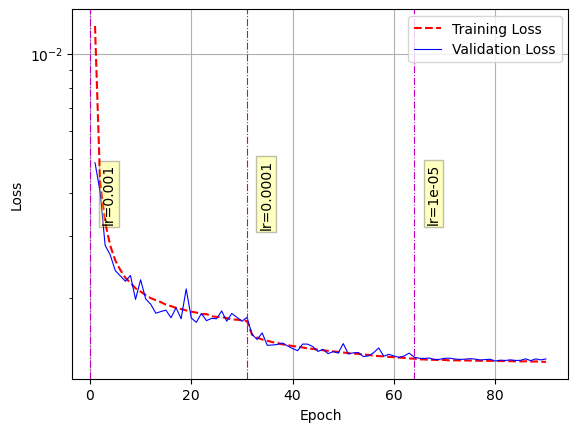

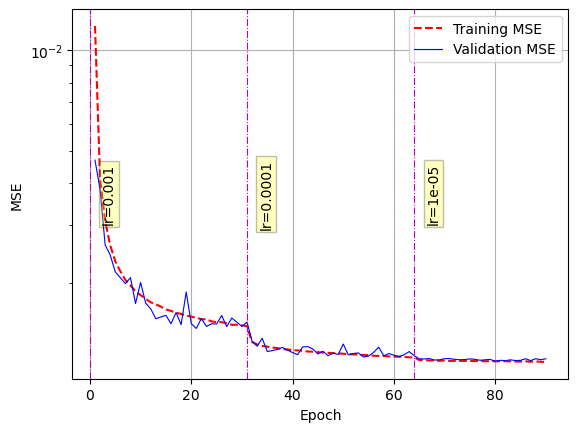

<Figure size 640x480 with 0 Axes>

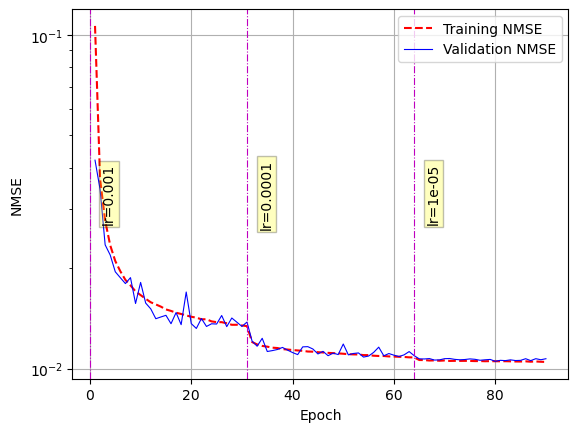

<Figure size 640x480 with 0 Axes>

In [32]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

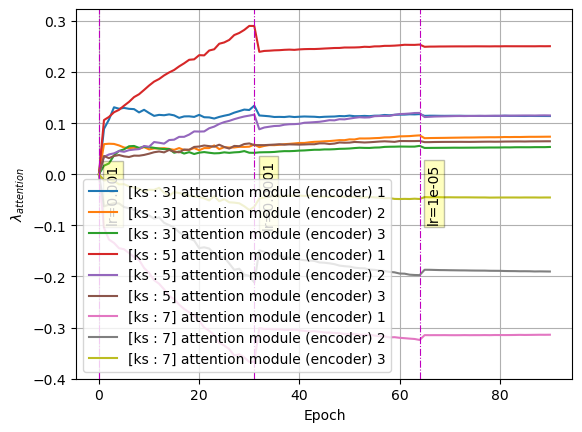

<Figure size 640x480 with 0 Axes>

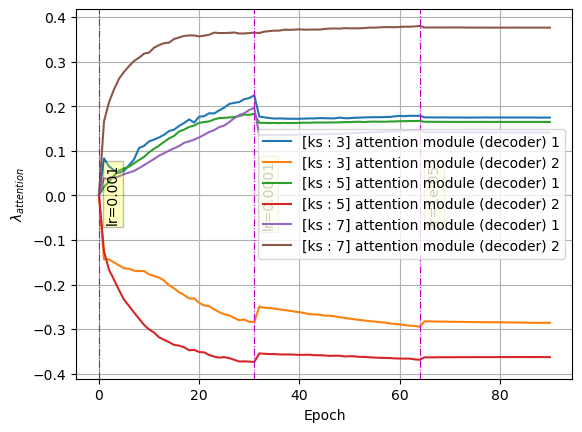

<Figure size 640x480 with 0 Axes>

In [33]:
if use_attention_module == True:
    # plotting encoder attention lambdas
    plot_lst = []
    legend_lst = []
    for ks_i in range(len(ae_net.kernel_size)):
        for i in range(len(ae_net.encoder_attention_modules_list[ks_i])):
            key = '{}__encoder_attention_module_{}_lambda'.format(ks_i, i)
            plot_lst.append(encoder_attention_lambdas[key])
            legend_lst.append(
                "[ks : {}] attention module (encoder) {}".format(
                    int(ae_net.kernel_size[ks_i]),
                    i+1
                )
            )
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_encoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    # plotting decoder attention lambdas
    plot_lst = []
    legend_lst = []
    for ks_i in range(len(ae_net.kernel_size)):
        for i in range(len(ae_net.decoder_attention_modules_list[ks_i])):
            key = '{}__decoder_attention_module_{}_lambda'.format(ks_i, i)
            plot_lst.append(decoder_attention_lambdas[key])
            legend_lst.append(
                "[ks : {}] attention module (decoder) {}".format(
                    int(ae_net.kernel_size[ks_i]),
                    i+1
                )
            )
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_decoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

# POD Comparison

In [34]:
# pod_training_data = np.empty(shape=(training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# pod_training_data[:, :] = np.reshape(training_data, (training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))

# pod_centering_means = np.mean(pod_training_data, axis=0)
# pod_mean_centered_data = pod_training_data - pod_centering_means

In [35]:
# C = np.transpose(pod_mean_centered_data) @ pod_mean_centered_data
# C /= pod_mean_centered_data.shape[0] - 1

In [36]:
# eigenvals, eigenvecs = np.linalg.eig(C)

In [37]:
# abs_eigenvals = np.abs(eigenvals)
# idx = np.argsort(abs_eigenvals)

In [38]:
# idx = idx[::-1]
# W = eigenvecs[:, idx[0:4*4*enc_filters[-1]]]

In [39]:
# reconstructed_val_data = val_data.reshape(val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]) @ W @ W.transpose()
# reconstructed_val_data = np.reshape(reconstructed_val_data, val_data.shape)

In [40]:
# val_recon_MSE = np.reshape((reconstructed_val_data - val_data)**2, (val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# val_recon_MSE = np.mean(np.sum(val_recon_MSE, axis=1), axis=0)

In [41]:
# print(val_recon_MSE, val_recon_MSE/np.sum(time_stddev**2), np.sum(time_stddev**2))

In [42]:
# abs_eigenvals[idx[0:4*4*2]]

In [43]:
s = ''
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.encoder_layers_list[ks_i])):
            l = ae_net.encoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('attention_module'):
                # print(i, name, l.lambda_att.numpy())
                s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
    
except:
    for i in range(len(ae_net.encoder_layers_list)):
        l = ae_net.encoder_layers_list[i]
        name = str(l.name)
        if name.startswith('attention_module'):
            # print(i, name, l.lambda_att.numpy())
            s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_encoder.txt', 'w') as f:
        f.write(s)

i : 8, name : attention_module, lambda_att : 0.11415468901395798
i : 13, name : attention_module_1, lambda_att : 0.07251739501953125
i : 18, name : attention_module_2, lambda_att : 0.05237659439444542
i : 8, name : attention_module_3, lambda_att : 0.25036540627479553
i : 13, name : attention_module_4, lambda_att : 0.11441736668348312
i : 18, name : attention_module_5, lambda_att : 0.06373703479766846
i : 8, name : attention_module_6, lambda_att : -0.3147774338722229
i : 13, name : attention_module_7, lambda_att : -0.18908657133579254
i : 18, name : attention_module_8, lambda_att : -0.0455605611205101



In [44]:
s = ''
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.decoder_layers_list[ks_i])):
            l = ae_net.decoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('attention_module'):
                # print(i, name, l.lambda_att.numpy())
                s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
except:
    for i in range(len(ae_net.decoder_layers_list)):
        l = ae_net.decoder_layers_list[i]
        name = str(l.name)
        if name.startswith('attention_module'):
            # print(i, name, l.lambda_att.numpy())
            s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_decoder.txt', 'w') as f:
        f.write(s)

i : 5, name : attention_module_9, lambda_att : 0.17452381551265717
i : 11, name : attention_module_10, lambda_att : -0.2846499979496002
i : 5, name : attention_module_11, lambda_att : 0.16464190185070038
i : 11, name : attention_module_12, lambda_att : -0.3627248704433441
i : 5, name : attention_module_13, lambda_att : 0.14099466800689697
i : 11, name : attention_module_14, lambda_att : 0.3761533200740814



In [45]:
try:
    s =  'ENCODED VECTOR WEIGHTS\n'
    s += '----------------------\n'
    for ks_i in range(ae_net.num_kernel_sizes):
        s += 'i : {:02d} -- kernel_size : {:02d} -- {:.5f}\n'.format(ks_i, ae_net.kernel_size[ks_i], ae_net.encoded_vec_weights[ks_i].value())
    s += '\n'
    s +=  'DECODED VECTOR WEIGHTS\n'
    s += '----------------------\n'
    for ks_i in range(ae_net.num_kernel_sizes):
        s += 'i : {:02d} -- kernel_size : {:02d} -- {:.5f}\n'.format(ks_i, ae_net.kernel_size[ks_i], ae_net.decoded_vec_weights[ks_i].value())
    print(s)
    with open(dir_name_ae + '/encoded_decoded_vec_weights.txt', 'w') as f:
        f.write(s)
except:
    pass

In [46]:
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.encoder_layers_list[ks_i])):
            l = ae_net.encoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('periodic_padding'):
                print(i, name, l.M_mat)
except:
    for i in range(len(ae_net.encoder_layers_list)):
        l = ae_net.encoder_layers_list[i]
        name = str(l.name)
        if name.startswith('periodic_padding'):
            print(i, name, l.M_mat)

0 periodic_padding <tf.Variable 'periodic_padding/M_mat:0' shape=(50, 50) dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>
4 periodic_padding_1 <tf.Variable 'periodic_padding_1/M_mat:0' shape=(26, 24) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [47]:
try:
    for ks_i in range(ae_net.num_kernel_sizes):
        for i in range(len(ae_net.decoder_layers_list[ks_i])):
            l = ae_net.decoder_layers_list[ks_i][i]
            name = str(l.name)
            if name.startswith('periodic_padding'):
                print(i, name, l.M_mat)
except:
    for i in range(len(ae_net.decoder_layers_list)):
        l = ae_net.decoder_layers_list[i]
        name = str(l.name)
        if name.startswith('periodic_padding'):
            print(i, name, l.M_mat)

0 periodic_padding_15 <tf.Variable 'periodic_padding_15/M_mat:0' shape=(5, 3) dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>
6 periodic_padding_16 <tf.Variable 'periodic_padding_16/M_mat:0' shape=(5, 3) dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>
12 periodic_padding_17 <tf.Variable 'periodic_padding_17/M_mat:0' shape=(8, 6) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)>
17 periodic_padding_18 <tf.Variable 'periodic_padding_18/M_mat:0' shape=(14, 12) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0.